<a href="https://colab.research.google.com/github/AyozeGS/IABD/blob/main/7RO/T9/7RO_DQN_Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ayoze Gil Sosa

# Reinforcement Learning: Deep Q Learning: CartPole

Este actividad pretende explicar cómo funciona el aprendizaje por refuerzo combinado con el uso de una red neuronal. Esta técnica es conocida como DQN.

DQN utiliza redes neuronales para estimar los valores Q de un agente en un entorno. En lugar de mantener una tabla de valores Q para cada estado utiliza una red neuronal para aproximar estos valores a partir de los estados observados. Esto permite al agente aprender políticas óptimas en entornos complejos y continuos.

En el proceso de actualización de los valores Q en Deep Q Bellman no se utiliza directamente el propio valor Q(s, a).

La fórmula utilizada actualiza el valor Q(s, a) con la suma de la recompensa actual y el valor Q máximo predicho para el siguiente estado s', ponderado por  el factor de descuento.


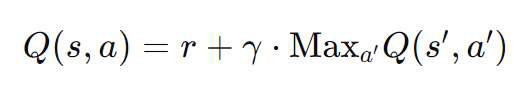




Utilizaremos el entorno CartPole-v0 en Gymnasium con el objetivo de equilibrar un poste aplicando fuerzas hacia la izquierda y la derecha sobre el carro. Tiene un espacio de acción discreto:

* 0: Empujar el carro hacia la izquierda
* 1: Empujar el carro hacia la derecha

Al tomar una acción, ya sea hacia la izquierda o hacia la derecha, un agente observa un estado de 4 dimensiones que consiste en:

* Posición del Carro
* Velocidad del Carro
* Ángulo del Poste
* Velocidad Angular del Poste

Se otorga una recompensa de al agente en cada paso mientras el poste se mantiene en posición vertical y se pierde si el Ángulo del Poste es mayor que ±12° o el Carro alcanza el borde de la pantalla.


En el proceso de actualización de los valores Q en Deep Q
Bellman, o sea en la fórmula para estimar el nuevo valor Q(s, a), no se utiliza directamente el propio valor Q(s, a).
La fórmula utilizada es:
Esta fórmula actualiza el valor Q(s, a) hacia el objetivo calculado, que es la suma


se organiza un agente de aprendizaje por refuerzo (DQN) y su interacción con un entorno utilizando la biblioteca Gym. La explicación detalla la inicialización, la recopilación de experiencias, la toma de decisiones (actuar), y el entrenamiento del modelo, junto con el almacenamiento de los resultados del aprendizaje.

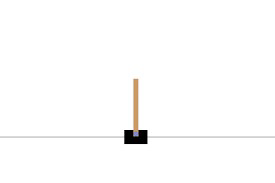

## Importa dependencias

In [ ]:
import numpy as np
import gym
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random
import os

## Configuración de Parametros

Configuración para evitar el uso de GPU en TensorFlow/Keras

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Inicialización del entorno de Gym con visualización

In [ ]:
env = gym.make('CartPole-v0', render_mode="human")

C:\Users\Ayo\AppData\Roaming\Python\Python311\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [ ]:
state_size = env.observation_space.shape[0]
state_size

4

In [ ]:
action_size = env.action_space.n
action_size

2

In [ ]:
batch_size = 32
n_episodes = 1000
output_dir = 'model_output/cartpole'

# Creación del directorio de salida si no existe
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Definición de la clase DQNAgent

In [ ]:
class DQNAgent():

    def __init__(self, state_size, action_size):

        # Inicializa el agente con sus parámetros y hiperparámetros.

        # Parámetros de estados y acciones para el input de la primera capa de la red neuronal
        self.state_size = state_size
        self.action_size = action_size

        # Instancia de una cola (deque) donde los elementos del principio serán automáticamente eliminados si se llena
        self.memory = deque(maxlen = 2000)

        # Factor de descuento
        self.gamma = 0.95

        # Parámetros Epsilon-gredy
        self.epsilon = 1.0 # Ratio inicial de exploración
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

        # Tasa de aprendizaje que controla cuánto se actualiza el modelo en base al error.
        self.learning_rate = 0.001

        # Modelo construido a partir del método existente en el agente.
        self.model = self.build_model()

    # Construye y compila el modelo de red neuronal para deep Q learning
    def build_model(self):

        model = Sequential()
        model.add(Dense(24, input_dim = self.state_size, activation = 'relu')) # first hidden layer
        model.add(Dense(24, activation = 'relu')) # first hidden layer
        model.add(Dense(self.action_size, activation = 'linear')) # output layer
        model.compile(loss = 'mse', optimizer = Adam(learning_rate = self.learning_rate))
        return model

    # Guarda en la memoria los parámetros propios de la ecuación de Bellman del aprendizaje por refuerzo.
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Realiza una acción de exploración o aleatoria en función del valor epsilon greedy.
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    # Entrena la red utilizando una minibatch de experiencias desde la memoria.
    def replay(self, batch_size):

        #Toma 16 muestras de la cola de memoria.
        minibatch = random.sample(self.memory, batch_size)

        # Se actualzia la matriz de recompensas y se entrena la red
        # utilizando las muestras de experiencia tomadas desde la cola
        for state, action, reward, next_state, done in minibatch:
            #Se actualiza la matriz de recomepnsas desde con la recompensa si se alcanza un estado final
            if done:
                target = reward
            # O se actualiza con la ecuación de Bellman
            else:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
                # target = R(s,a) + gamma * max Q`(s`,a`)
                # target (max Q` value) is output of Neural Network which takes s` as an input
                # amax(): flatten the lists (make them 1 list) and take max value
            train_target = self.model.predict(state, verbose=0) # s --> NN --> Q(s,a)=train_target
            train_target[0][action] = target
            # Se entrena el modelo
            self.model.fit(state, train_target, epochs=1, verbose = 0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # Carga los pesos del modelo desde un archivo
    def load(self, name):
        self.model.load_weights(name)

    # Guarda los pesos del modelo en un archivo
    def save(self, name):
        self.model.save_weights(name + ".weights.h5")

## Instanciación del agente

In [ ]:
agent = DQNAgent(state_size, action_size)

## Bucle principal de episodios para interacción con el entorno

In [ ]:
done = False
for e in range(n_episodes):

    # Se inicializa el entorno y se redimensiona el estado a la entrada de la red neuronal.
    state = env.reset()
    state = np.reshape(state[0], [1, state_size])

    # Simulación por eposicio
    for time in range(20000):

        env.render()

        # Se realiza una acción
        action = agent.act(state)

        # Se calculan los datos de la aplicar la acción
        next_state, reward, done, _, info  = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size])

        # Se alamacenan los nuevos datos en la cola
        agent.remember(state, action, reward, next_state, done)

        # Se actualiza el estado
        state = next_state

        # Se se alcanza un estado final se muestran los resultados del episodio y se pasa al siguiente
        if done:
            print("episode: {}/{}, score: {}, e: {:.2}".format(e, n_episodes, time, agent.epsilon))
            break

    # Si la memoria acumulada supera el tamaño de un lote se realiza un entrenamiento
    if len(agent.memory) > batch_size:
        agent.replay(batch_size) # memory is still not full

    # Guarda los pesos de la red neuronal del agente en un archivo cada 50 episodios
    if e % 50 == 0:
        agent.save(output_dir + "/weights_{:04d}".format(e))


C:\Users\Ayo\AppData\Roaming\Python\Python311\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode: 0/1000, score: 20, e: 1.0
episode: 1/1000, score: 14, e: 1.0
episode: 2/1000, score: 33, e: 0.99
episode: 3/1000, score: 21, e: 0.99
episode: 4/1000, score: 11, e: 0.99
episode: 5/1000, score: 21, e: 0.98
episode: 6/1000, score: 9, e: 0.98
episode: 7/1000, score: 16, e: 0.97
episode: 8/1000, score: 13, e: 0.97
episode: 9/1000, score: 21, e: 0.96
episode: 10/1000, score: 23, e: 0.96
episode: 11/1000, score: 21, e: 0.95
episode: 12/1000, score: 13, e: 0.95
episode: 13/1000, score: 28, e: 0.94
episode: 14/1000, score: 34, e: 0.94
episode: 15/1000, score: 13, e: 0.93
episode: 16/1000, score: 12, e: 0.93
episode: 17/1000, score: 13, e: 0.92
episode: 18/1000, score: 13, e: 0.92
episode: 19/1000, score: 36, e: 0.91
episode: 20/1000, score: 15, e: 0.91
episode: 21/1000, score: 44, e: 0.9
episode: 22/1000, score: 14, e: 0.9
episode: 23/1000, score: 15, e: 0.9
episode: 24/1000, score: 27, e: 0.89
episode: 25/1000, score: 22, e: 0.89
episode: 26/1000, score: 15, e: 0.88
episode: 27/1000,

Se observa que el aprendizaje es inestable, alcanzándose episodios con altas puntuaciones en episodios como los 357 a 360, pero no siendo capaz de mantener dichos puntuaciones. Se puede observar en los vídeos que se anexan.

En un enfoque DQN típico se utilizaría una segunda red llamada "red objetivo" para estabilizar los objetivos durante el aprendizaje. Esta red objetivo no se actualizaría en cada paso, sino a intervalos regulares.

